In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import warnings
from transformer_data import *
from sklearn.linear_model import ElasticNet, Lasso, Ridge
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
data = pd.read_csv("data/train.csv")
data = data.drop(columns=["Id"])

data = remove_outliers(data)

y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])
    
def get_true_scores():
    return pd.read_csv('result-with-best.csv')['SalePrice']

In [143]:
X_test = pd.read_csv('data/test.csv')
X_test = X_test.drop(columns=["Id"])
transformer = DataTransformer(StandardScaler())
y_train = y
X_train = transformer.prepare(X)
X_test = transformer.prepare(X_test)

transformer.fit(X_train)
X_train = transformer.transform(X_train, False)
X_test = transformer.transform(X_test, False)
to_categorical(X_train)
to_categorical(X_test)
cat_features = np.where(X_train.loc[:, X_train.columns.values].dtypes == 'category')[0]
def get_score(preds):
    res = pd.read_csv('result-with-best.csv')
    true = res['SalePrice']
    print(metrics.mean_squared_error(np.log(preds), np.log(true), squared=False))


In [156]:
sub = pd.read_csv('data/sample_submission.csv')

model = CatBoostRegressor(bagging_temperature=2.6989557582034918,random_state=12,one_hot_max_size=16,min_data_in_leaf=15,bootstrap_type='MVS',
                          boosting_type='Plain',depth=4,colsample_bylevel=0.09132567289331489,l2_leaf_reg=0.2444793233645477,learning_rate=0.07557969210733971,
                          loss_function='RMSE',iterations=700)
model.fit(X_train, y_train, verbose=0, cat_features=cat_features)
pred = model.predict(X_test)
sub['SalePrice'] = pred
sub['SalePrice']  = np.expm1(sub['SalePrice'])
sub.to_csv('submission.csv', index=False)
get_score(sub['SalePrice'])

0.13147029779908653


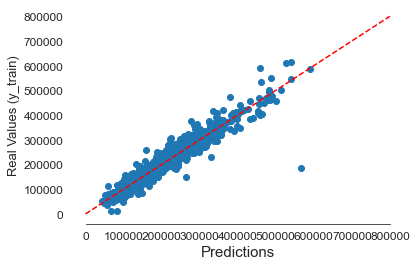

In [157]:
sns.set_style("white")
plt.scatter(sub['SalePrice'], get_true_scores())
plt.plot([0, 800000], [0, 800000], '--r')

plt.xlabel('Predictions', size=15)
plt.ylabel('Real Values (y_train)', size=13)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
sns.despine(trim=True, left=True)
plt.show()

# Regularization

In [158]:
X_test = pd.read_csv('data/test.csv')
X_test = X_test.drop(columns=["Id"])
transformer = DataTransformer(StandardScaler())
y_train = y
X_train = transformer.prepare(X)
X_test = transformer.prepare(X_test)

transformer.fit(X_train)
X_train = transformer.transform(X_train, True)
X_test = transformer.transform(X_test, True)

def get_score(preds):
    res = pd.read_csv('result-with-best.csv')
    true = res['SalePrice']
    print(metrics.mean_squared_error(np.log(preds), np.log(true), squared=False))



(1454, 24) (1454, 318)
(1459, 24) (1459, 318)


In [159]:
sub = pd.read_csv('data/sample_submission.csv')

lasso = Lasso(alpha=0.0003875227668814318,max_iter = 54696377)
ridge = Ridge(alpha=4.563672281359594)
elnet = ElasticNet(alpha=0.0004251979145220131, max_iter=2629425, l1_ratio=0.8952750683400642)
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)
elnet.fit(X_train, y_train)
pred = ((lasso.predict(X_test)) + (ridge.predict(X_test)) + (elnet.predict(X_test)))/3

sub['SalePrice'] = pred
sub['SalePrice']  = np.expm1(sub['SalePrice'])
q = sub['SalePrice'].quantile(0.9999)
sub['SalePrice'] = sub['SalePrice'].apply(lambda x: x if x < q else x * 0.1)
sub.to_csv('submission.csv', index=False)
get_score(sub['SalePrice'])

0.12677166407596888


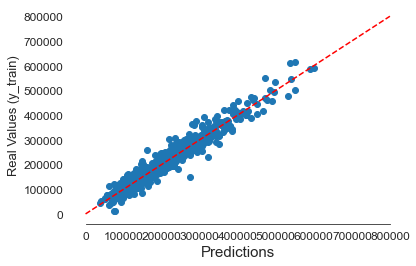

In [160]:
sns.set_style("white")
plt.scatter(sub['SalePrice'], get_true_scores())
plt.plot([0, 800000], [0, 800000], '--r')

plt.xlabel('Predictions', size=15)
plt.ylabel('Real Values (y_train)', size=13)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
sns.despine(trim=True, left=True)
plt.show()